          metric      value
        R2_train   0.750886
         R2_test   0.668759
sigma(RSE)_train   4.734795
         F_train  90.426617
         n_train 404.000000
               p  13.000000
             dof 390.000000


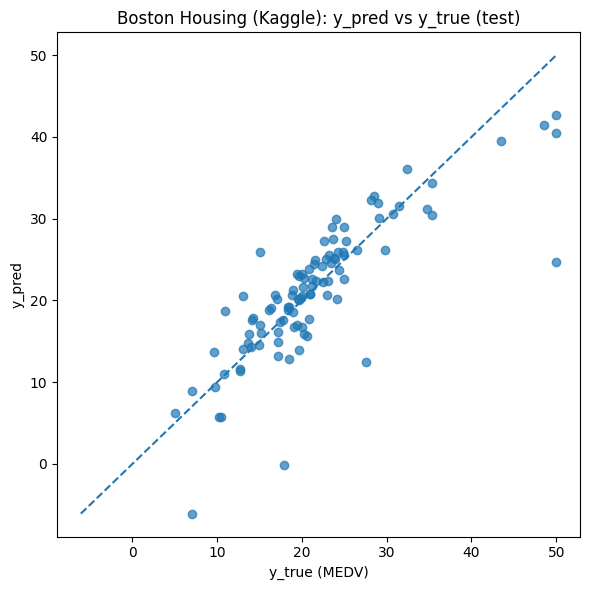

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

data_path = Path("chapters/kaggle_boston/boston.csv")

df = pd.read_csv(data_path)

# Target jest znany z opisu danych
target = "MEDV"
if target not in df.columns:
    raise ValueError(
        f"Brakuje kolumny `{target}` w danych. Dostępne kolumny: " + ", ".join(df.columns)
    )

# Bierzemy wszystkie cechy liczbowe poza targetem.
df_num = df.select_dtypes(include=[np.number])

tmp = df_num.dropna(subset=[target]).copy()
X = tmp.drop(columns=[target]).dropna()
y = tmp.loc[X.index, target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

reg = LinearRegression()
reg.fit(X_train, y_train)

# predykcje
y_pred_train = reg.predict(X_train)
y_pred_test = reg.predict(X_test)

# R^2
r2_train = reg.score(X_train, y_train)
r2_test = reg.score(X_test, y_test)

# „klasyczne” podsumowanie regresji (liczone na zbiorze treningowym)
n = X_train.shape[0]
p = X_train.shape[1]
dof = n - p - 1

resid = y_train.values - y_pred_train
sse = np.sum(resid**2)  # sum of squared errors
tss = np.sum((y_train.values - y_train.mean())**2)
ssr = tss - sse         # sum of squares regression

sigma = np.sqrt(sse / dof)          # residual std. error (RSE)
F = (ssr / p) / (sse / dof)         # F-statistic dla H0: beta_1=...=beta_p=0

summary = pd.DataFrame({
    "metric": ["R2_train", "R2_test", "sigma(RSE)_train", "F_train", "n_train", "p", "dof"],
    "value":  [r2_train, r2_test, sigma, F, n, p, dof],
})
print(summary.to_string(index=False))

# wykres: y_true vs y_pred (zbiór testowy)
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred_test, alpha=0.7)
mn = min(y_test.min(), y_pred_test.min())
mx = max(y_test.max(), y_pred_test.max())
plt.plot([mn, mx], [mn, mx], linestyle="--")
plt.xlabel(f"y_true ({target})")
plt.ylabel("y_pred")
plt.title("Boston Housing (Kaggle): y_pred vs y_true (test)")
plt.tight_layout()
plt.show()

/opt/homebrew/Cellar/python@3.12/3.12.12/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/opt/homebrew/Cellar/python@3.12/3.12.12/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/opt/homebrew/Cellar/python@3.12/3.12.12/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See h

Najlepsze hiperparametry (CV):
  lambda (model__alpha)   = 0.01
  alpha  (model__l1_ratio)= 0.000
  CV R^2 (mean)           = 0.7245

Podsumowanie ElasticNet:
              metric    value
            R2_train 0.750670
             R2_test 0.667571
          RMSE_train 4.654048
           RMSE_test 4.937440
         best_lambda 0.010000
best_alpha(l1_ratio) 0.000000

Największe (bezwzględnie) współczynniki ElasticNet:
feature      coef
  LSTAT -3.562197
     RM  3.167423
    DIS -2.939338
PTRATIO -1.999596
    RAD  1.966321
    NOX -1.901429
    TAX -1.510458
      B  1.120095
   CRIM -0.964915
   CHAS  0.732337


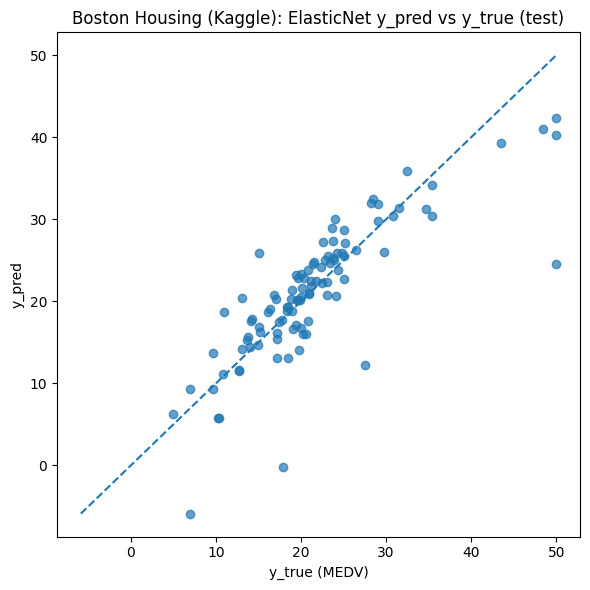

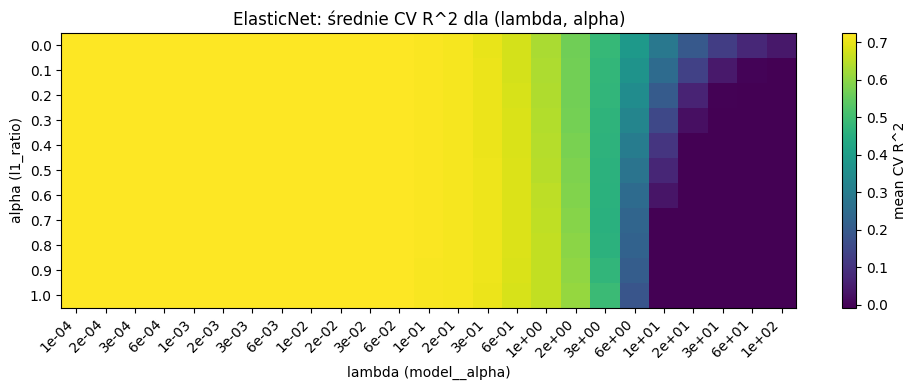

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNet
from sklearn.metrics import r2_score, mean_squared_error

# ----------------------------
# 1) Wczytanie i przygotowanie danych (jak u Ciebie)
# ----------------------------
data_path = Path("chapters/kaggle_boston/boston.csv")
df = pd.read_csv(data_path)

target = "MEDV"
if target not in df.columns:
    raise ValueError(
        f"Brakuje kolumny `{target}` w danych. Dostępne kolumny: " + ", ".join(df.columns)
    )

df_num = df.select_dtypes(include=["number"]).copy()
tmp = df_num.dropna(subset=[target]).copy()

X = tmp.drop(columns=[target]).dropna()
y = tmp.loc[X.index, target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ----------------------------
# 2) Pipeline: standaryzacja + ElasticNet
# ----------------------------
pipe = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("model", ElasticNet(max_iter=50_000, random_state=42))
])

# ----------------------------
# 3) Kalibracja (GridSearch): lambda i alpha
#    - lambda -> model__alpha
#    - alpha  -> model__l1_ratio
# ----------------------------
# Sensowna siatka: logarytmiczna dla lambda
lambda_grid = np.logspace(-4, 2, 25)      # 1e-4 ... 1e2
alpha_grid = np.linspace(0.0, 1.0, 11)    # 0, 0.1, ..., 1.0

param_grid = {
    "model__alpha": lambda_grid,          # lambda (siła kary)
    "model__l1_ratio": alpha_grid         # alpha (mieszanka L1/L2)
}

# CV: w regresji klasycznie KFold; domyślnie GridSearchCV użyje KFold
# Skoring: R^2, bo tak raportujesz w przykładzie
search = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring="r2",
    cv=5,
    n_jobs=-1
)

search.fit(X_train, y_train)

best_model = search.best_estimator_
best_params = search.best_params_
best_cv_r2 = search.best_score_

print("Najlepsze hiperparametry (CV):")
print(f"  lambda (model__alpha)   = {best_params['model__alpha']:.6g}")
print(f"  alpha  (model__l1_ratio)= {best_params['model__l1_ratio']:.3f}")
print(f"  CV R^2 (mean)           = {best_cv_r2:.4f}")

# ----------------------------
# 4) Ocena na train/test + metryki jak w Twoim stylu
# ----------------------------
y_pred_train = best_model.predict(X_train)
y_pred_test = best_model.predict(X_test)

r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)

# Dodatkowo RMSE (często użyteczne w regresji)
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))

summary = pd.DataFrame({
    "metric": ["R2_train", "R2_test", "RMSE_train", "RMSE_test", "best_lambda", "best_alpha(l1_ratio)"],
    "value":  [r2_train, r2_test, rmse_train, rmse_test, best_params["model__alpha"], best_params["model__l1_ratio"]],
})
print("\nPodsumowanie ElasticNet:")
print(summary.to_string(index=False))

# ----------------------------
# 5) Współczynniki po regularyzacji (już po standaryzacji)
# ----------------------------
# Uwaga: współczynniki dotyczą cech po standaryzacji (porównywalne między sobą).
coefs = best_model.named_steps["model"].coef_
coef_table = pd.DataFrame({"feature": X.columns, "coef": coefs}).sort_values("coef", key=np.abs, ascending=False)

print("\nNajwiększe (bezwzględnie) współczynniki ElasticNet:")
print(coef_table.head(10).to_string(index=False))

# ----------------------------
# 6) Wykres: y_true vs y_pred (test)
# ----------------------------
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred_test, alpha=0.7)
mn = min(y_test.min(), y_pred_test.min())
mx = max(y_test.max(), y_pred_test.max())
plt.plot([mn, mx], [mn, mx], linestyle="--")
plt.xlabel(f"y_true ({target})")
plt.ylabel("y_pred")
plt.title("Boston Housing (Kaggle): ElasticNet y_pred vs y_true (test)")
plt.tight_layout()
plt.show()

# ----------------------------
# 7) (Opcjonalnie) mapa wyników: R^2 w funkcji (lambda, alpha)
# ----------------------------
# To jest przydatne dydaktycznie: pokazuje krajobraz hiperparametrów.
results = pd.DataFrame(search.cv_results_)
pivot = results.pivot_table(
    index="param_model__l1_ratio",
    columns="param_model__alpha",
    values="mean_test_score"
).sort_index()

plt.figure(figsize=(10, 4))
plt.imshow(pivot.values, aspect="auto")
plt.colorbar(label="mean CV R^2")
plt.yticks(range(pivot.shape[0]), [f"{v:.1f}" for v in pivot.index])
plt.xticks(range(pivot.shape[1]), [f"{v:.0e}" for v in pivot.columns], rotation=45, ha="right")
plt.ylabel("alpha (l1_ratio)")
plt.xlabel("lambda (model__alpha)")
plt.title("ElasticNet: średnie CV R^2 dla (lambda, alpha)")
plt.tight_layout()
plt.show()


                 model  mean_R2   std_R2      q25   median      q75
LinearRegression (OLS) 0.712943 0.059862 0.671914 0.719919 0.762099
    Ridge (alpha=0.01) 0.712945 0.059863 0.671911 0.719929 0.762106


/var/folders/vw/flytd6691vvf0823861tdc0m0000gn/T/ipykernel_66849/3458731022.py:56: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([scores_ols, scores_ridge], labels=["OLS", "Ridge"], showfliers=True)


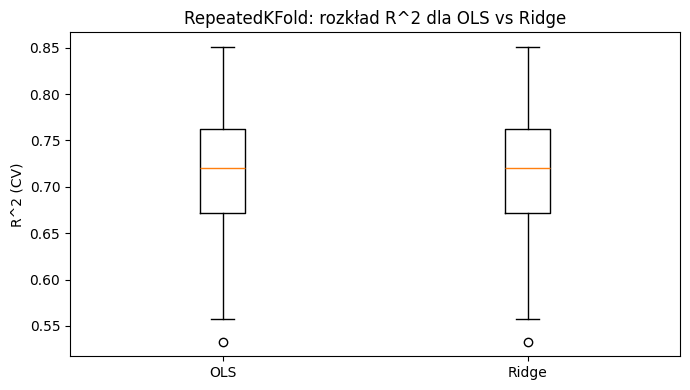


Stabilizacja (mniejsza zmienność wyników CV jest korzystna):
Std(R^2) OLS  : 0.0599
Std(R^2) Ridge: 0.0599


In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import RepeatedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge

# Zakładam, że masz już X, y jak w Twoim przykładzie:
# X = tmp.drop(columns=[target]).dropna()
# y = tmp.loc[X.index, target]

# ----------------------------
# 1) RepeatedKFold (powtarzana walidacja krzyżowa)
# ----------------------------
cv = RepeatedKFold(n_splits=5, n_repeats=20, random_state=42)

# ----------------------------
# 2) Modele do porównania
#    - OLS: LinearRegression (bez regularyzacji)
#    - Ridge: regularyzacja L2; skalowanie w pipeline (ważne)
# ----------------------------
ols = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("model", LinearRegression())
])

ridge = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("model", Ridge(alpha=0.01, random_state=42))
])

# ----------------------------
# 3) R^2 w RepeatedKFold
# ----------------------------
scores_ols = cross_val_score(ols, X, y, cv=cv, scoring="r2", n_jobs=-1)
scores_ridge = cross_val_score(ridge, X, y, cv=cv, scoring="r2", n_jobs=-1)

# Podsumowanie liczbowe: średnia, odchylenie, kwartyle
summary = pd.DataFrame({
    "model": ["LinearRegression (OLS)", "Ridge (alpha=0.01)"],
    "mean_R2": [scores_ols.mean(), scores_ridge.mean()],
    "std_R2": [scores_ols.std(ddof=1), scores_ridge.std(ddof=1)],
    "q25": [np.quantile(scores_ols, 0.25), np.quantile(scores_ridge, 0.25)],
    "median": [np.quantile(scores_ols, 0.50), np.quantile(scores_ridge, 0.50)],
    "q75": [np.quantile(scores_ols, 0.75), np.quantile(scores_ridge, 0.75)],
})

print(summary.to_string(index=False))

# ----------------------------
# 4) Boxplot wyników
# ----------------------------
plt.figure(figsize=(7, 4))
plt.boxplot([scores_ols, scores_ridge], labels=["OLS", "Ridge"], showfliers=True)
plt.ylabel("R^2 (CV)")
plt.title("RepeatedKFold: rozkład R^2 dla OLS vs Ridge")
plt.tight_layout()
plt.show()

# ----------------------------
# 5) „Stabilizacja” wprost: porównanie wariancji wyników
# ----------------------------
print("\nStabilizacja (mniejsza zmienność wyników CV jest korzystna):")
print(f"Std(R^2) OLS  : {scores_ols.std(ddof=1):.4f}")
print(f"Std(R^2) Ridge: {scores_ridge.std(ddof=1):.4f}")


README.md: 0.00B [00:00, ?B/s]

train.csv: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/683 [00:00<?, ? examples/s]

PRZED kalibracją progu (threshold=0.50) – metryki OOF:
  accuracy : 0.9693
  precision: 0.9580
  recall   : 0.9540
  f1       : 0.9560
  roc_auc  : 0.9951

Macierz pomyłek (rows=true, cols=pred):
 [[434  10]
 [ 11 228]]


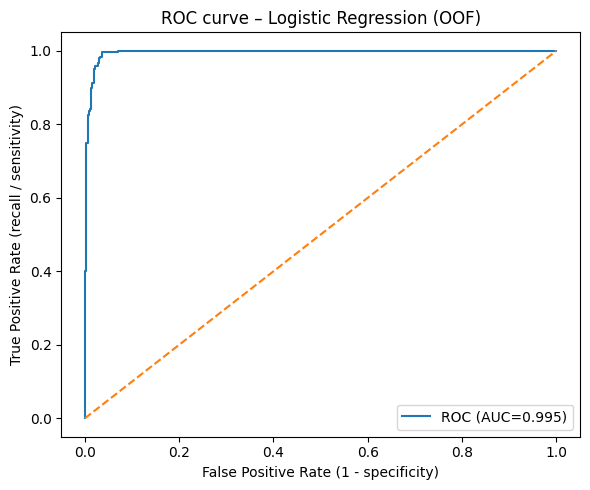


Skalibrowany próg (Youden J): 0.1299

PO kalibracji progu (Youden J) – metryki OOF:
  accuracy : 0.9751
  precision: 0.9370
  recall   : 0.9958
  f1       : 0.9655
  roc_auc  : 0.9951

Macierz pomyłek (rows=true, cols=pred):
 [[428  16]
 [  1 238]]


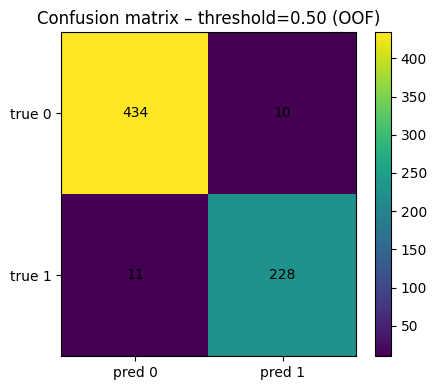

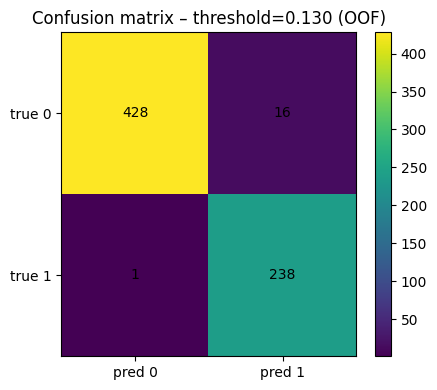

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datasets import load_dataset

from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import (
    confusion_matrix,
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve
)

# =========================
# 1) Wczytanie danych z Hugging Face
# =========================
# Dataset ma jeden split "train" (683 obserwacje) i target "is_cancer"
ds = load_dataset("mstz/breast", "cancer")["train"]  # :contentReference[oaicite:1]{index=1}
df = ds.to_pandas()

target = "is_cancer"
y = df[target].astype(int)

X = df.drop(columns=[target])

# Minimalnie: imputacja (gdyby były braki) + standaryzacja + logreg
pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("model", LogisticRegression(max_iter=2000, solver="lbfgs"))
])

# =========================
# 2) Walidacja krzyżowa i out-of-fold predykcje prawdopodobieństw
# =========================
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# out-of-fold: każda obserwacja ma proba z modelu, który jej "nie widział" w treningu
proba_oof = cross_val_predict(
    pipe, X, y,
    cv=cv,
    method="predict_proba"
)[:, 1]

# Predykcja klasy przy standardowym progu 0.5
thr_default = 0.50
y_pred_default = (proba_oof >= thr_default).astype(int)

# =========================
# 3) Metryki + confusion matrix (PRZED kalibracją progu)
# =========================
def compute_metrics(y_true, y_pred, proba):
    return {
        "accuracy":  accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred, zero_division=0),
        "recall":    recall_score(y_true, y_pred, zero_division=0),
        "f1":        f1_score(y_true, y_pred, zero_division=0),
        "roc_auc":   roc_auc_score(y_true, proba),
    }

metrics_default = compute_metrics(y, y_pred_default, proba_oof)
cm_default = confusion_matrix(y, y_pred_default)

print("PRZED kalibracją progu (threshold=0.50) – metryki OOF:")
for k, v in metrics_default.items():
    print(f"  {k:9s}: {v:.4f}")
print("\nMacierz pomyłek (rows=true, cols=pred):\n", cm_default)

# =========================
# 4) ROC curve (z OOF proba)
# =========================
fpr, tpr, thresholds = roc_curve(y, proba_oof)
auc = roc_auc_score(y, proba_oof)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"ROC (AUC={auc:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate (1 - specificity)")
plt.ylabel("True Positive Rate (recall / sensitivity)")
plt.title("ROC curve – Logistic Regression (OOF)")
plt.legend()
plt.tight_layout()
plt.show()

# =========================
# 5) Kalibracja progu (Youden’s J)
#    J = TPR - FPR = sensitivity + specificity - 1
# =========================
J = tpr - fpr
idx = np.argmax(J)
thr_calibrated = thresholds[idx]

print(f"\nSkalibrowany próg (Youden J): {thr_calibrated:.4f}")

y_pred_cal = (proba_oof >= thr_calibrated).astype(int)

metrics_cal = compute_metrics(y, y_pred_cal, proba_oof)
cm_cal = confusion_matrix(y, y_pred_cal)

print("\nPO kalibracji progu (Youden J) – metryki OOF:")
for k, v in metrics_cal.items():
    print(f"  {k:9s}: {v:.4f}")
print("\nMacierz pomyłek (rows=true, cols=pred):\n", cm_cal)

# =========================
# 6) Porównanie confusion matrices: wizualizacja
# =========================
def plot_cm(cm, title):
    plt.figure(figsize=(4.5, 4))
    plt.imshow(cm, aspect="auto")
    plt.title(title)
    plt.colorbar()
    plt.xticks([0, 1], ["pred 0", "pred 1"])
    plt.yticks([0, 1], ["true 0", "true 1"])
    for i in range(2):
        for j in range(2):
            plt.text(j, i, cm[i, j], ha="center", va="center")
    plt.tight_layout()
    plt.show()

plot_cm(cm_default, "Confusion matrix – threshold=0.50 (OOF)")
plot_cm(cm_cal, f"Confusion matrix – threshold={thr_calibrated:.3f} (OOF)")


In [23]:
from sklearn.metrics import precision_recall_curve, confusion_matrix

# =========================
# Kalibracja progu wg maksymalizacji F1
# =========================
prec, rec, thr = precision_recall_curve(y, proba_oof)
# precision_recall_curve zwraca: len(prec)=len(rec)=len(thr)+1
# F1 liczymy dla punktów odpowiadających progom thr
f1_scores = 2 * (prec[:-1] * rec[:-1]) / (prec[:-1] + rec[:-1] + 1e-12)

best_idx = int(f1_scores.argmax())
thr_f1 = float(thr[best_idx])

print(f"Skalibrowany próg (maks. F1): {thr_f1:.4f}")
print(f"  Precision@thr: {prec[best_idx]:.4f}")
print(f"  Recall@thr   : {rec[best_idx]:.4f}")
print(f"  F1@thr       : {f1_scores[best_idx]:.4f}")

# Predykcje po kalibracji progu
y_pred_f1 = (proba_oof >= thr_f1).astype(int)

# =========================
# Wyniki PRZED vs PO (OOF)
# =========================
metrics_default = compute_metrics(y, (proba_oof >= 0.50).astype(int), proba_oof)
cm_default = confusion_matrix(y, (proba_oof >= 0.50).astype(int))

metrics_f1 = compute_metrics(y, y_pred_f1, proba_oof)
cm_f1 = confusion_matrix(y, y_pred_f1)

print("\nPRZED kalibracją (threshold=0.50) – metryki OOF:")
for k, v in metrics_default.items():
    print(f"  {k:9s}: {v:.4f}")
print("Macierz pomyłek:\n", cm_default)

print("\nPO kalibracji progu (maks. F1) – metryki OOF:")
for k, v in metrics_f1.items():
    print(f"  {k:9s}: {v:.4f}")
print("Macierz pomyłek:\n", cm_f1)


Skalibrowany próg (maks. F1): 0.1299
  Precision@thr: 0.9370
  Recall@thr   : 0.9958
  F1@thr       : 0.9655

PRZED kalibracją (threshold=0.50) – metryki OOF:
  accuracy : 0.9693
  precision: 0.9580
  recall   : 0.9540
  f1       : 0.9560
  roc_auc  : 0.9951
Macierz pomyłek:
 [[434  10]
 [ 11 228]]

PO kalibracji progu (maks. F1) – metryki OOF:
  accuracy : 0.9751
  precision: 0.9370
  recall   : 0.9958
  f1       : 0.9655
  roc_auc  : 0.9951
Macierz pomyłek:
 [[428  16]
 [  1 238]]
